## Исследование записей ЭКГ с использованием biosppy 

In [1]:
import wfdb
import numpy as np
import biosppy
from biosppy import signals
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import norm
import seaborn as sb

In [2]:
class ECGTrack:
    def __init__(self, signal, sample_rate, tag='', computeECG=True):
        self.signal = signal
        self.sample_rate = sample_rate
        self.tag = tag
        if (computeECG):
            self.process()
        
    def process(self): #extract biosppy heartbeat data
        if (self.signal.size > 255 and not hasattr(self,'ecginfo')):
            self.ecginfo=signals.ecg.ecg(self.signal, sampling_rate=self.sample_rate,show=False)
    
    def showECGPlots(self): #biosppy summary plot
        self.process()
        biosppy.plotting.plot_ecg(
            ts=self.ecginfo['ts'], 
            raw=self.signal, 
            filtered=self.ecginfo['filtered'], 
            rpeaks=self.ecginfo['rpeaks'], 
            templates_ts=self.ecginfo['templates_ts'], 
            templates=self.ecginfo['templates'], 
            heart_rate_ts=self.ecginfo['heart_rate_ts'], 
            heart_rate=self.ecginfo['heart_rate'], 
            path=None, show=True)
    
    def plot(self): #amplitude plot
        plt.plot(np.linspace(0, self.signal.size/self.sample_rate, self.signal.size), self.signal)
        plt.title(self.tag)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.show()
            
    def rpeaks(self):
        self.process()
        return self.ecginfo['rpeaks']
    
    def heartbeat_rate_params(self):
        mean = np.mean(self.ecginfo['heart_rate'])
        var = np.var(self.ecginfo['heart_rate'])
        fourth = np.mean((self.ecginfo['heart_rate'] - mean)**4)
        return mean, var, fourth
    
    def main_rpeaks(self):
        lengths = self.segment_lengths()
        median_length = np.mean(self.segment_lengths())
        tol = 0.1 * self.sample_rate
        main_rpeaks = self.rpeaks()[1:][np.abs(lengths - median_length) < tol]
        return main_rpeaks
    
    def rpeak_values(self):
        return self.signal[self.rpeaks()]
    
    def rpeak_val_params(self):
        vals = self.rpeak_values()
        return np.mean(vals), np.var(vals)
    
    def segment_lengths(self): #segment length
        self.process()
        return np.ediff1d(self.rpeaks())
    
    def segment_length_params(self): #segment length mean and variance
        lengths = self.segment_lengths() / self.sample_rate
        mean = np.mean(lengths)
        var = np.var(lengths)
        fourth = np.mean((lengths - mean)**4)
        return mean, var, fourth
    
    def heart_rate(self):
        return np.mean(self.ecginfo['heart_rate'])
    
    def heartbeat_templates(self):
        self.process()
        return self.ecginfo['templates']
    
    def avg_hb_template(self): #get average segment
        return np.mean(self.heartbeat_templates(), axis=0)
    
    def avg_hb_record(self):
        return ECGTrack(self.avg_hb_template(), self.sample_rate, self.tag + ' average segment')
    
    def split_track(self, nparts):
        signals = np.array_split(self.signal, nparts)
        return [ECGTrack(s, self.sample_rate, self.tag) for s in signals]
    
    def get_features(self): #feature set for ML
        return np.ravel(np.array[
            self.heart_rate(),
            self.segment_length_params(),
            self.rpeak_val_params(),
            self.avg_hb_template()
        ])
    
        
class ECGRecord:
    def __init__(self, records, tag):
        self.records = records
        self.tag = tag
        
    def fromWFDB(wfdbrecord):
        records = []
        sample_rate = wfdbrecord.__dict__['fs']
        tag = wfdbrecord.__dict__['comments'][0]
        #separate channels
        for i in range(wfdbrecord.__dict__['n_sig']):
            track = ECGTrack(wfdbrecord.__dict__['p_signal'][:,i], sample_rate, tag + ', channel ' + str(i))
            records.append(track)
        return ECGRecord(records, tag)
    
    def fromWFDBfile(path_name): 
        #path_name - path to database folder that contains .dat, .hea, .atr files plus record name without extension
        return ECGRecord.fromWFDB(wfdb.rdrecord(path_name)) #read MIT database format
    
    def plot(self):
        for r in self.records:
            r.plot()
            
    def split_record(self, nparts):
        table = [x.split_track(nparts) for x in self.records]
        res = []
        for i in range(nparts):
            res.append(ECGRecord(table[:,i], self.tag + ' part ' + str(i)))
        return res
    
    def get_features(self): #feature set for ML
        return np.ravel(np.array([x.get_features() for x in records]))

Загружаем записи из базы данных. Обработка записей занимает много времени, поэтому ограничимся рассмотрением записей Rh2001-Rh2009

In [3]:
records = []
for i in range(4):
    records.append(ECGRecord.fromWFDBfile('ECG/RohmineEcgDatabase/Rh200'+str(i+1)))

Построим графики biosppy для первых двух записей: исходный (амплитуда от времени), фильтрованный (амплитуда от времени), моментальная частота сердцебиения от времени, общий график сегментов (на временном интервале, соответствующим одному R-R сегменту, все R-R сегменты, найденные на записи, изображаются тонкими полупрозрачными линиями)

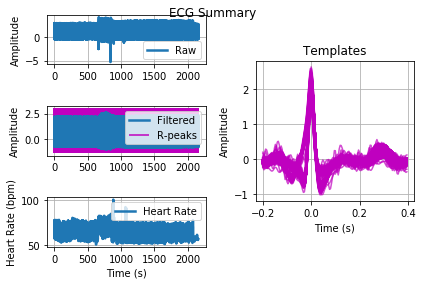

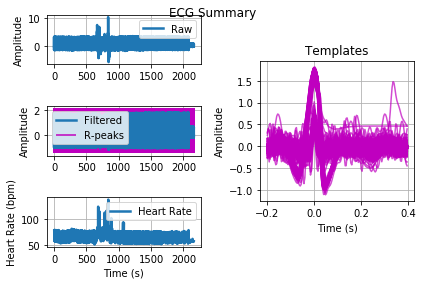

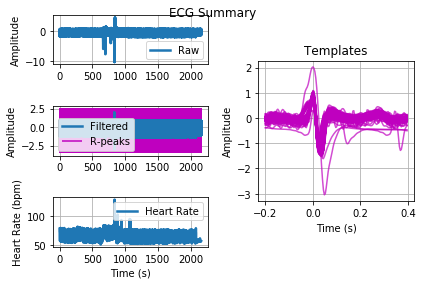

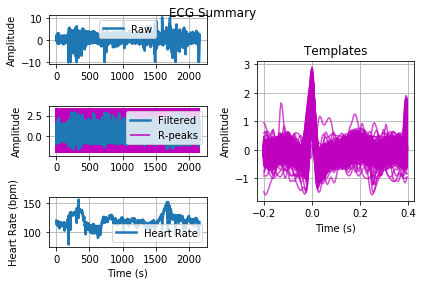

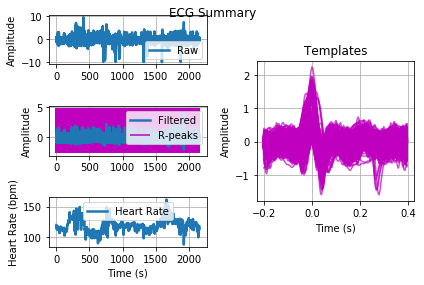

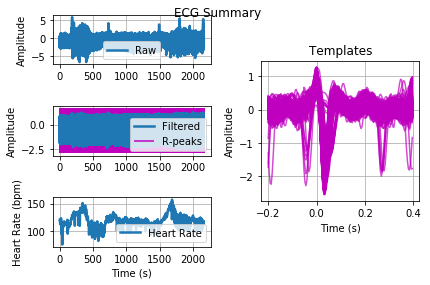

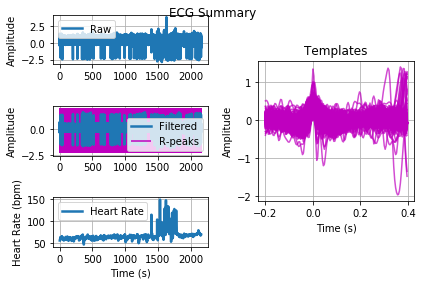

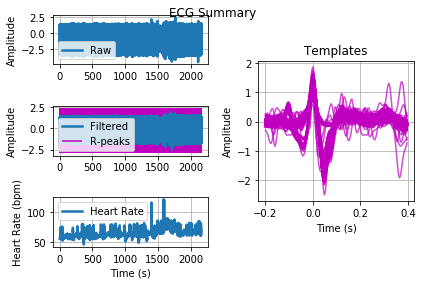

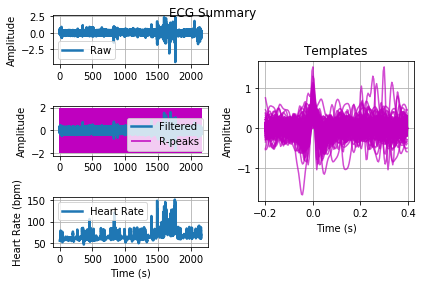

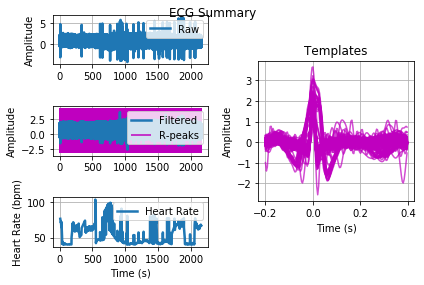

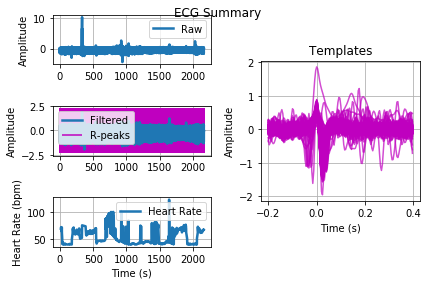

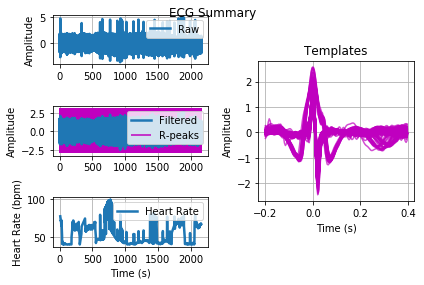

In [4]:
for r in records:
    for x in r.records:
        x.showECGPlots()

### Статистические свойства R-пиков
Как известно, при нормальном сердцебиение одному сердечному циклу соответствует один R-пик, а значит расстояние между соседними R-пиками должно быть распределено нормально. При некоторых заболеваниях возникают дополнительные R-пики и/или смещение их фазы, то есть распределение расстояний перестает быть нормальным. Значит, параметры распределения длин сегментов (=расстояний между соседними R-пиками) могут быть полезны как характеристики для классификации болезней. Построим графики этого распределения для данных записей (по оси X - длина интервала между соседними R-пиками, по оси Y - вероятность встретить соответствующую частоту на записи)

Record tag:  ЖЭ, Ж тригеминия, channel 0
heart rate:  65.01104795403906 ; variance:  0.057136406367341915 ; fourth moment:  0.011260240306484658


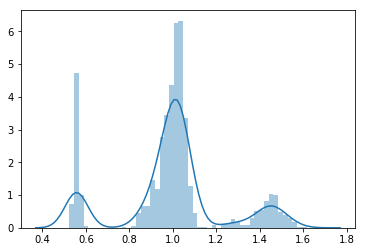

Record tag:  ЖЭ, Ж тригеминия, channel 1
heart rate:  65.54692162254585 ; variance:  0.06595372866471684 ; fourth moment:  0.028002297289954407


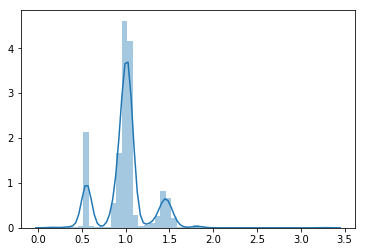

Record tag:  ЖЭ, Ж тригеминия, channel 2
heart rate:  65.90116532784992 ; variance:  0.06469444614539188 ; fourth moment:  0.021850840140902335


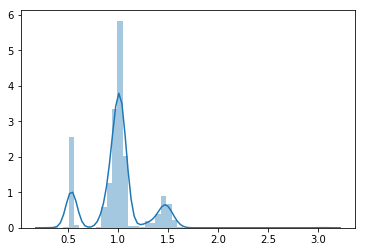

Record tag:  ЖЭ. Дрейф базовой линии, channel 0
heart rate:  120.69511022642864 ; variance:  0.002653386123420219 ; fourth moment:  0.000535733919085911


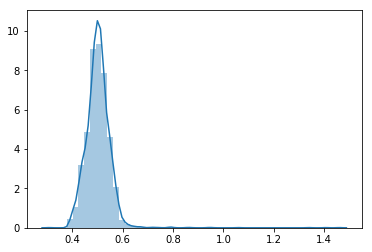

Record tag:  ЖЭ. Дрейф базовой линии, channel 1
heart rate:  120.58561558582181 ; variance:  0.003318380530712971 ; fourth moment:  0.0009258584397129766


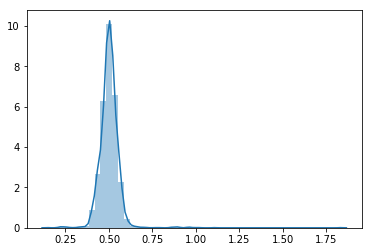

Record tag:  ЖЭ. Дрейф базовой линии, channel 2
heart rate:  120.03553595014799 ; variance:  0.005733142427768516 ; fourth moment:  0.0010666031935662632


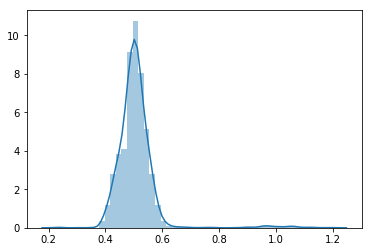

Record tag:  ЖЭ и N оригинальной формы, channel 0
heart rate:  66.35850070070462 ; variance:  0.05151455064403448 ; fourth moment:  0.036587770092761346


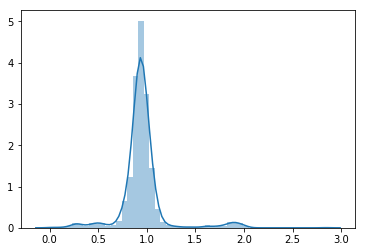

Record tag:  ЖЭ и N оригинальной формы, channel 1
heart rate:  65.71146865849492 ; variance:  0.015182165040479737 ; fourth moment:  0.0015521037543854768


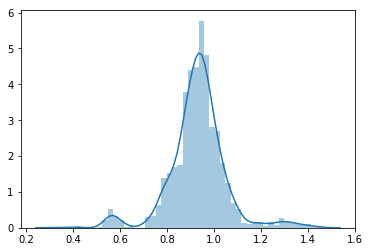

Record tag:  ЖЭ и N оригинальной формы, channel 2
heart rate:  68.09815899849121 ; variance:  0.03303435962033353 ; fourth moment:  0.008002401002505861


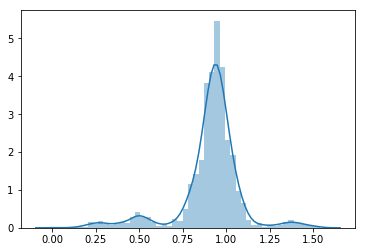

Record tag:  ЖЭ, НЖЭ и паузы, channel 0
heart rate:  56.41290013145915 ; variance:  0.08150665161732747 ; fourth moment:  0.013694071646743734


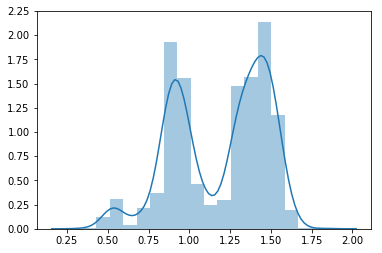

Record tag:  ЖЭ, НЖЭ и паузы, channel 1
heart rate:  56.331815813158734 ; variance:  0.08992197953795705 ; fourth moment:  0.022874056149661624


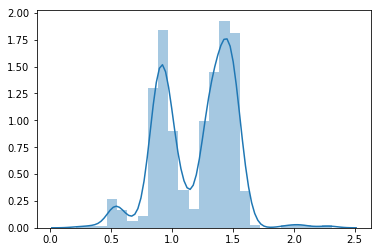

Record tag:  ЖЭ, НЖЭ и паузы, channel 2
heart rate:  56.13821440094806 ; variance:  0.08051055306455122 ; fourth moment:  0.013229434073839912


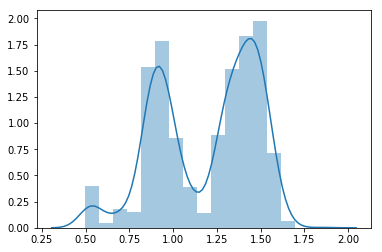

In [7]:
for r in records:
    for x in r.records:
        mean, var, fourth = x.segment_length_params()
        print('Record tag: ', x.tag)
        print('heart rate: ', x.heart_rate(), '; variance: ', var, '; fourth moment: ', fourth)
        sb.distplot(x.segment_lengths() / x.sample_rate)
        plt.show()

Для некоторых заболеваний характерно не только наличие нескольких R-пиков в одном сегменте, но также различная величина этих пиков. Построим график распределения величины найденных пиков:

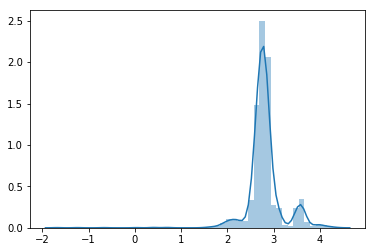

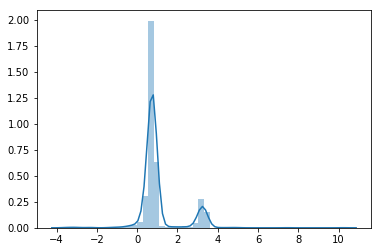

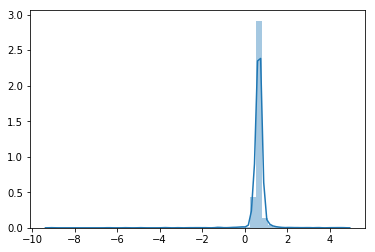

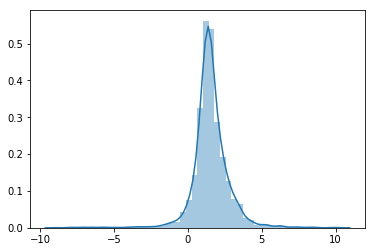

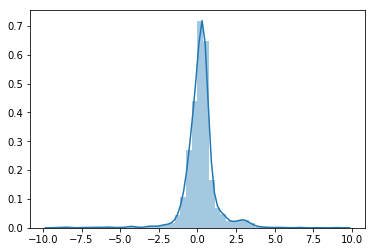

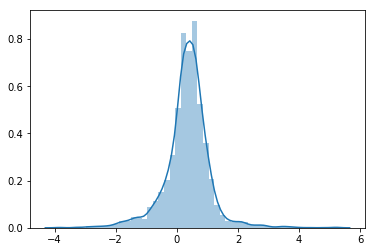

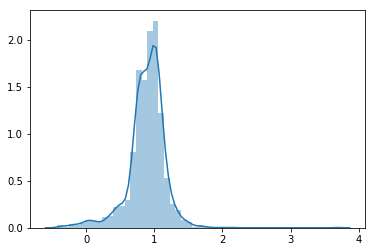

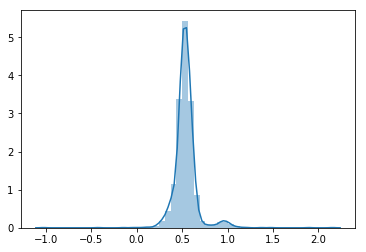

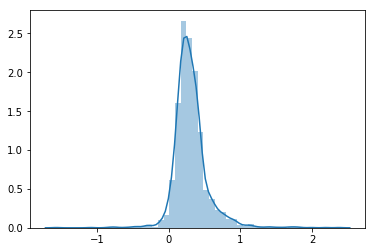

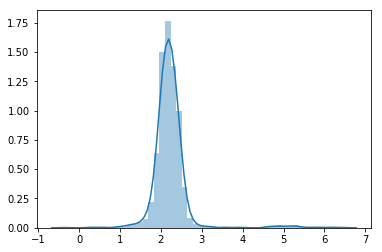

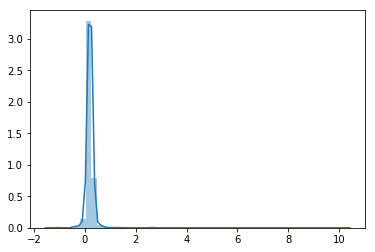

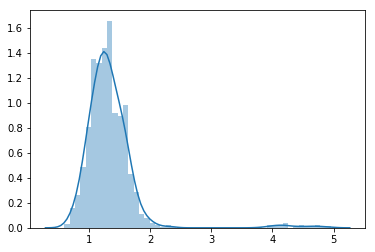

In [6]:
for r in records:
    for x in r.records:
        sb.distplot(x.rpeak_values())
        plt.show()

#### Вывод
Распределения длин сегментов достаточно сильно отличаются между записями и имеют вид multimodal distribution, этим можно воспользоваться чтобы извлечь характеристики, а именно параметры этих распределений. Предлагается с помощью scipy.fit_curve произвести оценку параметров в модели trimodal distribution (судя по построенным графикам, наиболее общий случай) по имеющимся данным и использовать эти оценки для задачи классификации. Однако перед этим стоит убедиться, что такое распределение соответствует самим данным, а не возникает из-за шума или ошибок методов сегментации biosppy.

### Итог
<ul>
    <li> Библиотека WFDB позволяет без особых проблем обрабатывать данные в формате MIT database, но использование этого формата для хранения полученных данных в рамках проекта SonosIntra вряд ли целесобразно </li>
    <li> Библиотека biosppy позволяет фильтровать сигнал ЭКГ от помех и находить с очень высокой точностью положения R-пиков, с помощью которых легко получить такие характеристики как длину сегментов, моментальную частоту сердцебиения и усредненный R-R сегмент, из которого в свою очередь можно выделить относительное положение характерных точек (QRS) и соответствующих интервалов </li>
    <li> Для использования в алгоритмах ML в дальнейшем можно будет использовать перечисленные выше характеристики, а также параметры распределения длин сегментов
